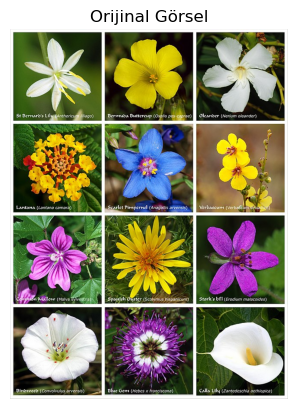

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from skimage.feature import hog
from skimage import color

img_bgr = cv2.imread("C:/Users/Zelal_Yilmaz/Downloads/gorsel.jpg")

if img_bgr is None:
    print("⚠️ Görsel yüklenemedi! Dosya yolunu kontrol et.")
else:
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.title("Orijinal Görsel")
    plt.axis("off")
    plt.show()


Bu kod görüntüyü gri formata çevirip Canny, Sobel ve Laplacian yöntemleriyle kenarları tespit ederek karşılaştırmalı olarak görselleştirir.

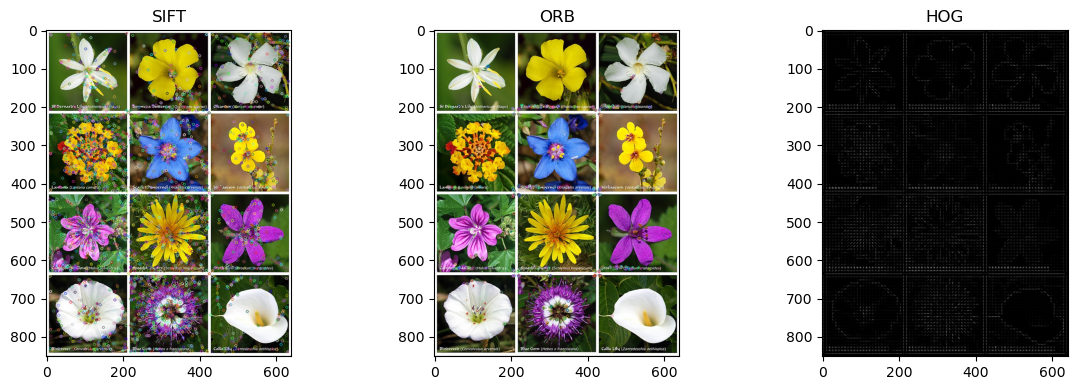

In [2]:
#  SIFT 
sift = cv2.SIFT_create()
kp_sift, des_sift = sift.detectAndCompute(img_rgb, None)
img_sift = cv2.drawKeypoints(img_rgb, kp_sift, None)

#  ORB 
orb = cv2.ORB_create()
kp_orb, des_orb = orb.detectAndCompute(img_rgb, None)
img_orb = cv2.drawKeypoints(img_rgb, kp_orb, None)

#  HOG 
gray_scaled = color.rgb2gray(img_rgb)
fd, hog_image = hog(gray_scaled, visualize=True)

# Görselleştirme
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1); plt.imshow(img_sift); plt.title("SIFT")
plt.subplot(1, 3, 2); plt.imshow(img_orb); plt.title("ORB")
plt.subplot(1, 3, 3); plt.imshow(hog_image, cmap='gray'); plt.title("HOG")
plt.tight_layout(); plt.show()


Bu kod görseldeki önemli noktaları SIFT ve ORB ile belirler, kenar yönü tabanlı HOG özniteliklerini çıkarıp görselleştirir.

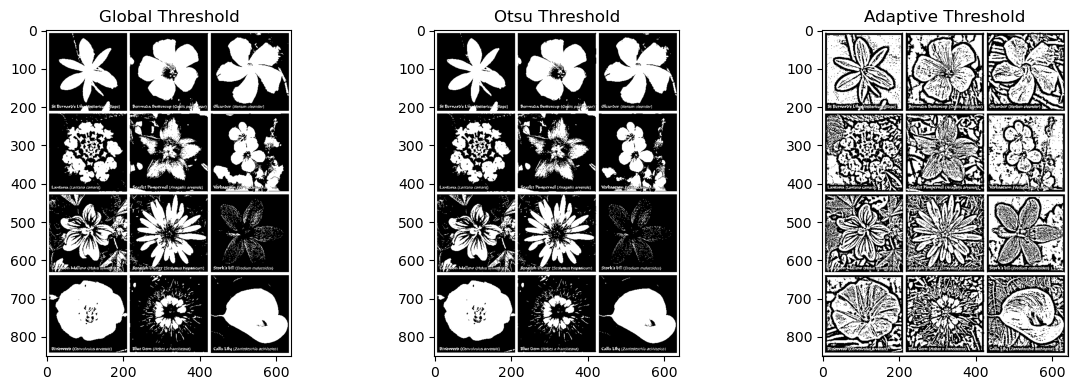

In [3]:
# Griye çevirme 
gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)

# 1. Global 
_, thresh_global = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)

# 2. Otsu 
_, thresh_otsu = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# 3. Adaptive Thresholding 
thresh_adaptive = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C,
                                        cv2.THRESH_BINARY, 11, 2)

# Görselleştirme
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1); plt.imshow(thresh_global, cmap='gray'); plt.title("Global Threshold")
plt.subplot(1, 3, 2); plt.imshow(thresh_otsu, cmap='gray'); plt.title("Otsu Threshold")
plt.subplot(1, 3, 3); plt.imshow(thresh_adaptive, cmap='gray'); plt.title("Adaptive Threshold")
plt.tight_layout(); plt.show()


bu kod gri görüntüyü farklı eşikleme yöntemleriyle siyah-beyaz hale getirerek bölgeleri ayırır ve görselleştirir.

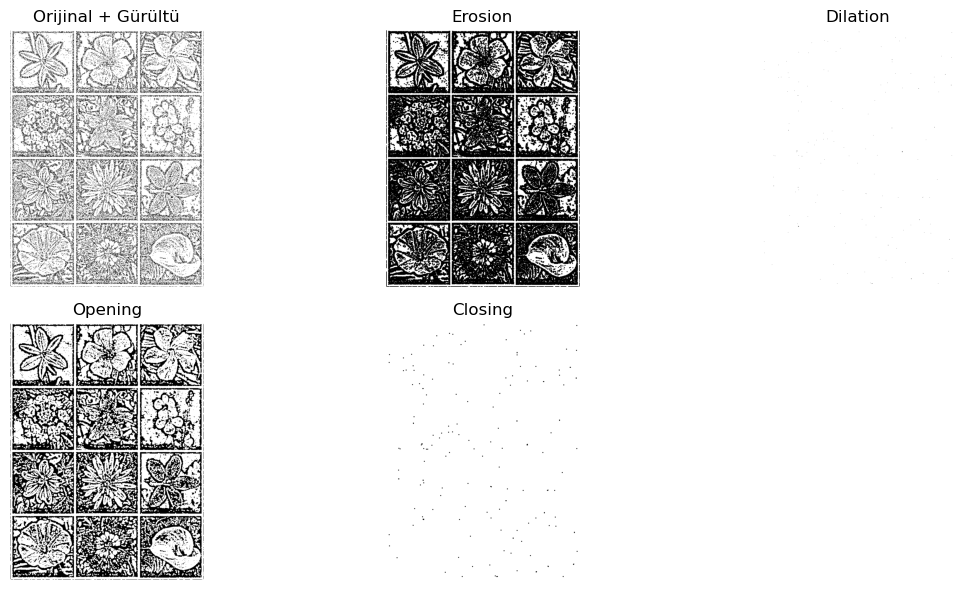

In [4]:
# Önce threshold uygulanmış bir görüntü  kullanıyoruz
binary = thresh_adaptive.copy()

# Gürültü ekleyelim 
noise = np.random.randint(0, 2, size=binary.shape, dtype=np.uint8) * 255
binary_noise = cv2.bitwise_or(binary, noise)

# Yapısal eleman 
kernel = np.ones((3, 3), np.uint8)

# Erosion
erosion = cv2.erode(binary_noise, kernel, iterations=1)

# Dilation 
dilation = cv2.dilate(binary_noise, kernel, iterations=1)

# Opening 
opening = cv2.morphologyEx(binary_noise, cv2.MORPH_OPEN, kernel)

# Closing 
closing = cv2.morphologyEx(binary_noise, cv2.MORPH_CLOSE, kernel)

plt.figure(figsize=(12, 6))
titles = ["Orijinal + Gürültü", "Erosion", "Dilation", "Opening", "Closing"]
images = [binary_noise, erosion, dilation, opening, closing]

for i in range(5):
    plt.subplot(2, 3, i+1)
    plt.imshow(images[i], cmap='gray')
    plt.title(titles[i])
    plt.axis('off')

plt.tight_layout()
plt.show()


Bu kod gürültülü siyah-beyaz görüntüye temel morfolojik işlemleri uygulayarak şekil düzeltme ve gürültü temizleme yapar.

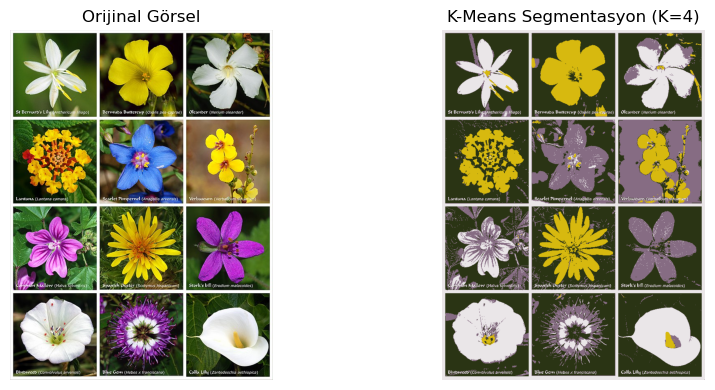

In [5]:
# Görseli (R, G, B) 3 boyutlu diziden 2 boyutlu dizine dönüştürme kodu
Z = img_rgb.reshape((-1, 3))
Z = np.float32(Z)

# K-Means kriterleri
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
K = 4  # 4 renk kümesidir

# K-Means algoritmasını uygulama kodu
_, labels, centers = cv2.kmeans(Z, K, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

# Sonuçları yeniden görüntü formatına dönüştürür
centers = np.uint8(centers)
segmented_data = centers[labels.flatten()]
segmented_img = segmented_data.reshape((img_rgb.shape))

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1); plt.imshow(img_rgb); plt.title("Orijinal Görsel"); plt.axis('off')
plt.subplot(1, 2, 2); plt.imshow(segmented_img); plt.title(f"K-Means Segmentasyon (K={K})"); plt.axis('off')
plt.tight_layout(); plt.show()


Bu kod görseldeki benzer renkleri gruplayarak görüntüyü K renk kümesine ayırır ve segmentasyon işlemini uygular.

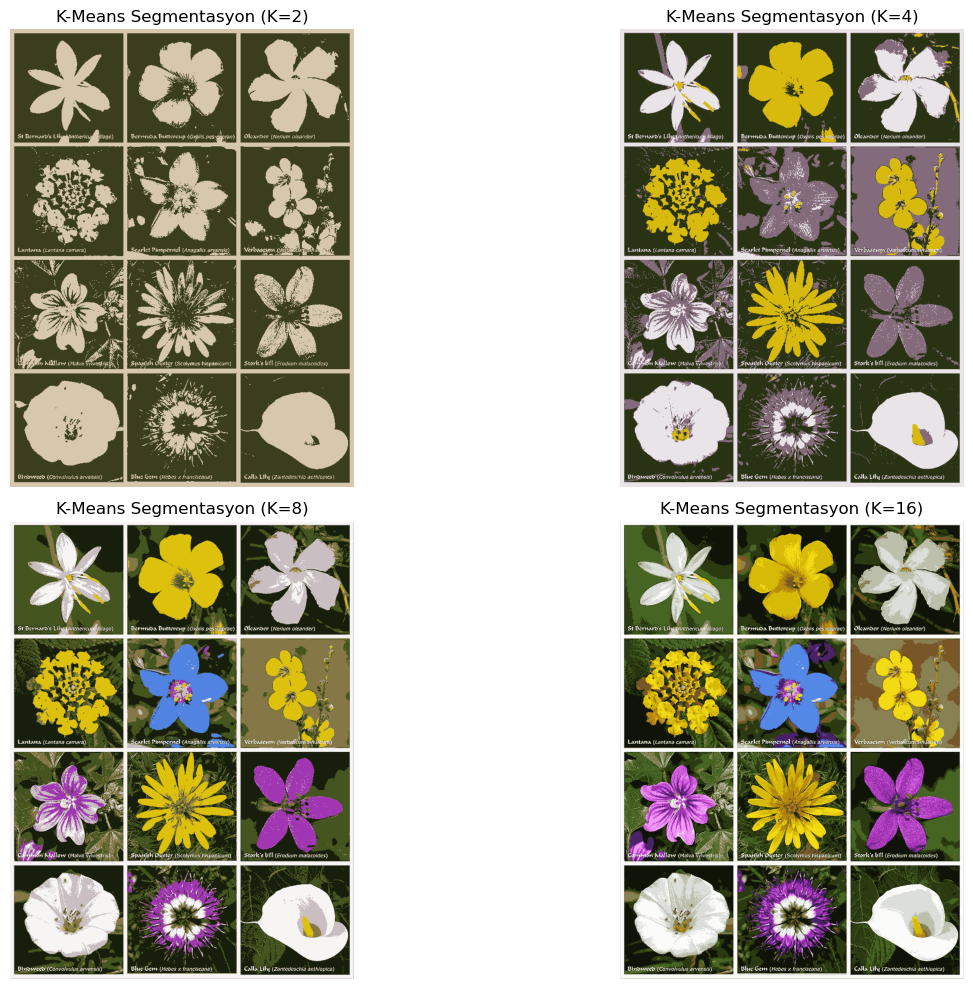

In [6]:
Ks = [2, 4, 8, 16]  # Denenecek cluster sayılarıdır
plt.figure(figsize=(15, 10))

for i, K in enumerate(Ks):
    _, labels, centers = cv2.kmeans(Z, K, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
    centers = np.uint8(centers)
    segmented_data = centers[labels.flatten()]
    segmented_img = segmented_data.reshape(img_rgb.shape)
    
    plt.subplot(2, 2, i+1)
    plt.imshow(segmented_img)
    plt.title(f"K-Means Segmentasyon (K={K})")
    plt.axis('off')

plt.tight_layout()
plt.show()


Bu kod bi önceki koddaki verilen cluster sayısını artırıp azaltarak (örneğin K=2,4,8,16) segmentasyonun nasıl değiştiğini de gözlemleyerek cluster sayısının etkisini gösteriyor.

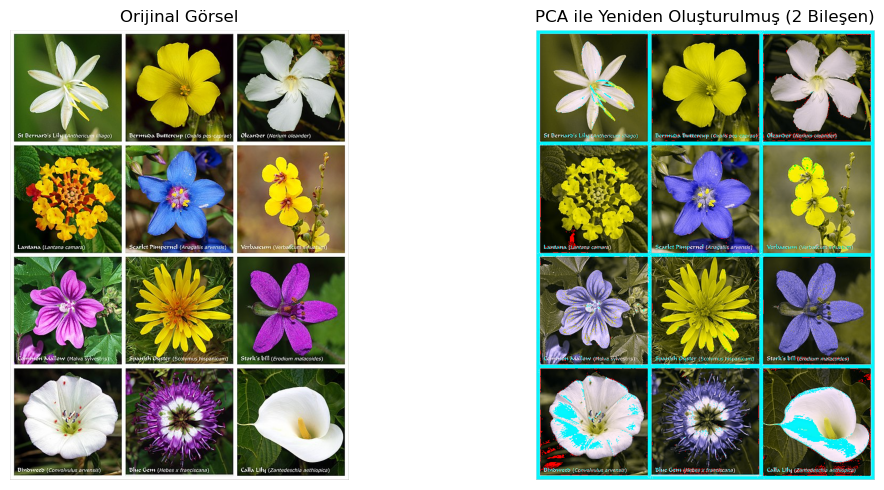

In [7]:
# PCA için RGB görüntüyü (yükseklik x genişlik x 3) → (piksel sayısı x 3) yapıyor
pixels = img_rgb.reshape(-1, 3)

# PCA uygulayarak 2 bileşene indiriyoruz
pca = PCA(n_components=2)
pixels_pca = pca.fit_transform(pixels)

# PCA’dan orijinal hale geri dönüş 
pixels_reconstructed = pca.inverse_transform(pixels_pca)

# Yeniden uint8 yapıp görüntü şeklinde düzenliyor
img_reconstructed = pixels_reconstructed.reshape(img_rgb.shape).astype(np.uint8)

# Görselleştirme
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.imshow(img_rgb)
plt.title("Orijinal Görsel")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(img_reconstructed)
plt.title("PCA ile Yeniden Oluşturulmuş (2 Bileşen)")
plt.axis('off')

plt.tight_layout()
plt.show()


Bu kod görseldeki renk bilgisini PCA ile iki bileşene indirgenip sıkıştırır ve sonra geri oluşturularak orijinalle karşılaştırır.